#### 1 _ Nous Allons Commencer Par Importer Les Bibliothèques Nécessaires

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pour Treatement general de donnees
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random

In [ ]:
# Tensorflow et Keras pour le model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

#### Maintenant, nous définissons des variables générales que nous allons utiliser plus tard

In [ ]:
DIR = "/content/drive/MyDrive/archive/kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

In [ ]:
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []

In [ ]:
patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|██████████| 112/112 [07:40<00:00,  4.11s/it]


In [ ]:
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)

In [ ]:
print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


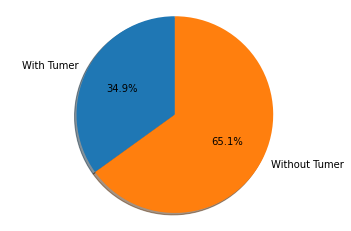

In [ ]:
labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') 
plt.show()

#### Construire le test et le train pour notre dataset

In [ ]:
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)

In [ ]:
#nombre des images en validation
with_tumer_val_images = 300
without_tumer_val_images = 600

#nombre des images en test
with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

In [ ]:
print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [ ]:
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [ ]:
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

#### Visualisation de notre Dataset

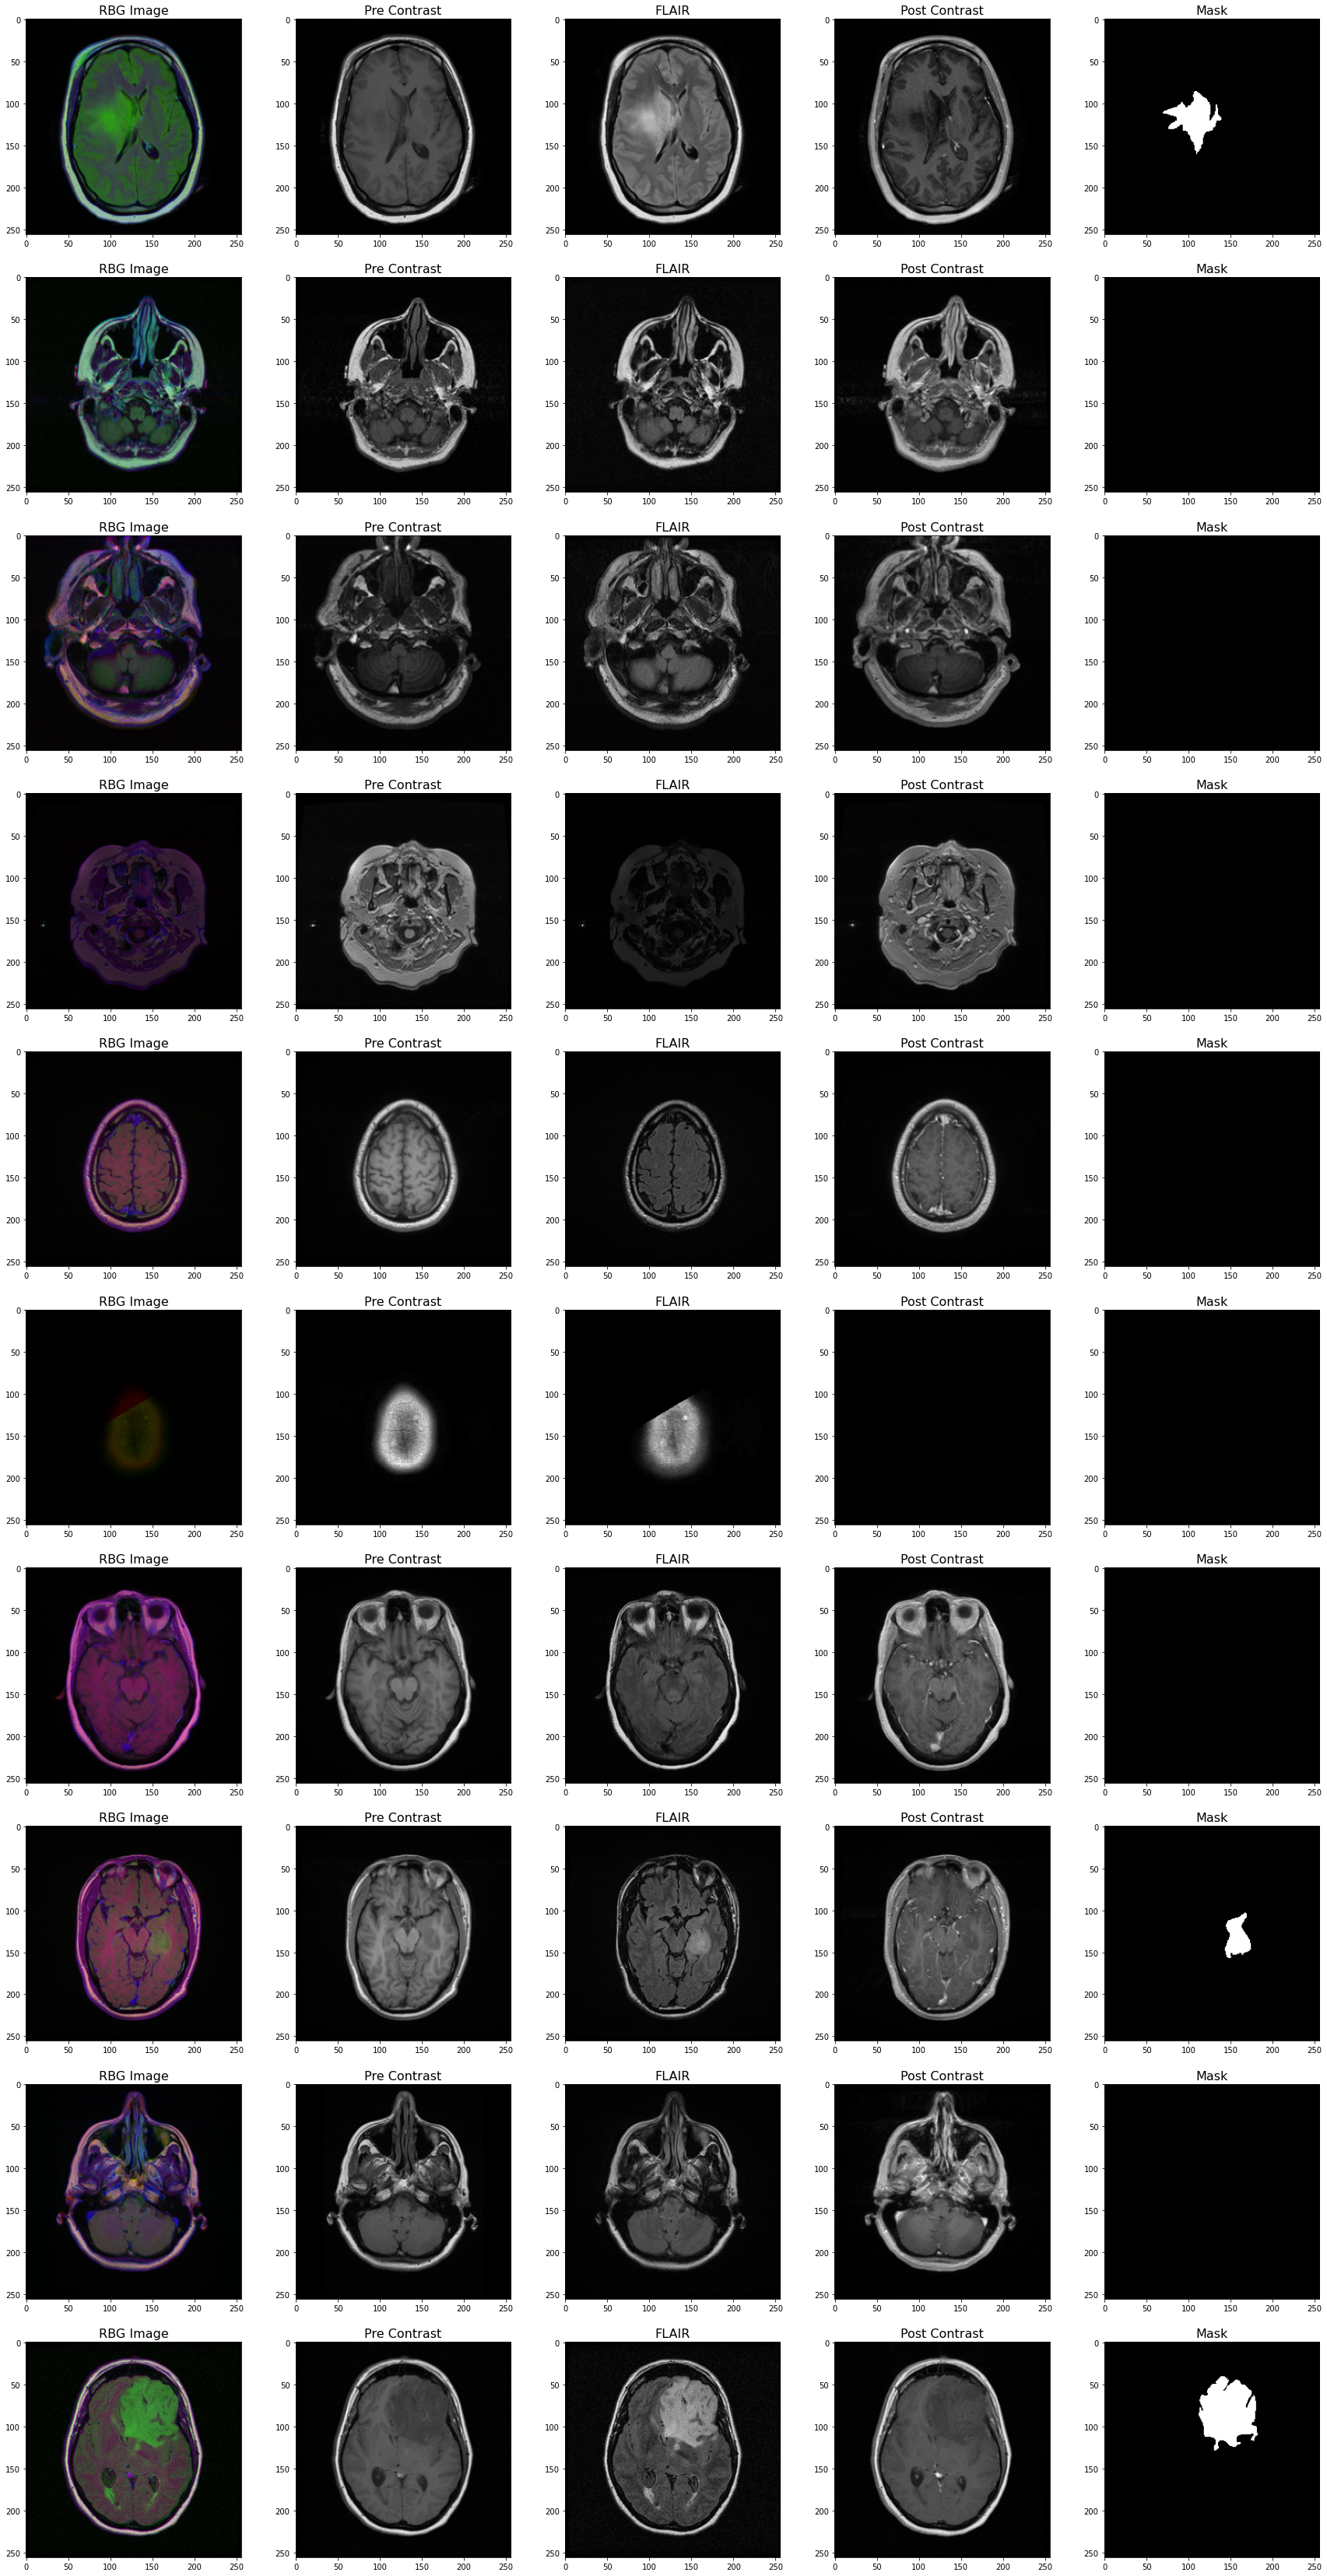

In [ ]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 1000, 3)
    
    mri = np.asarray(load_img(
         join(DIR, train_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, train_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

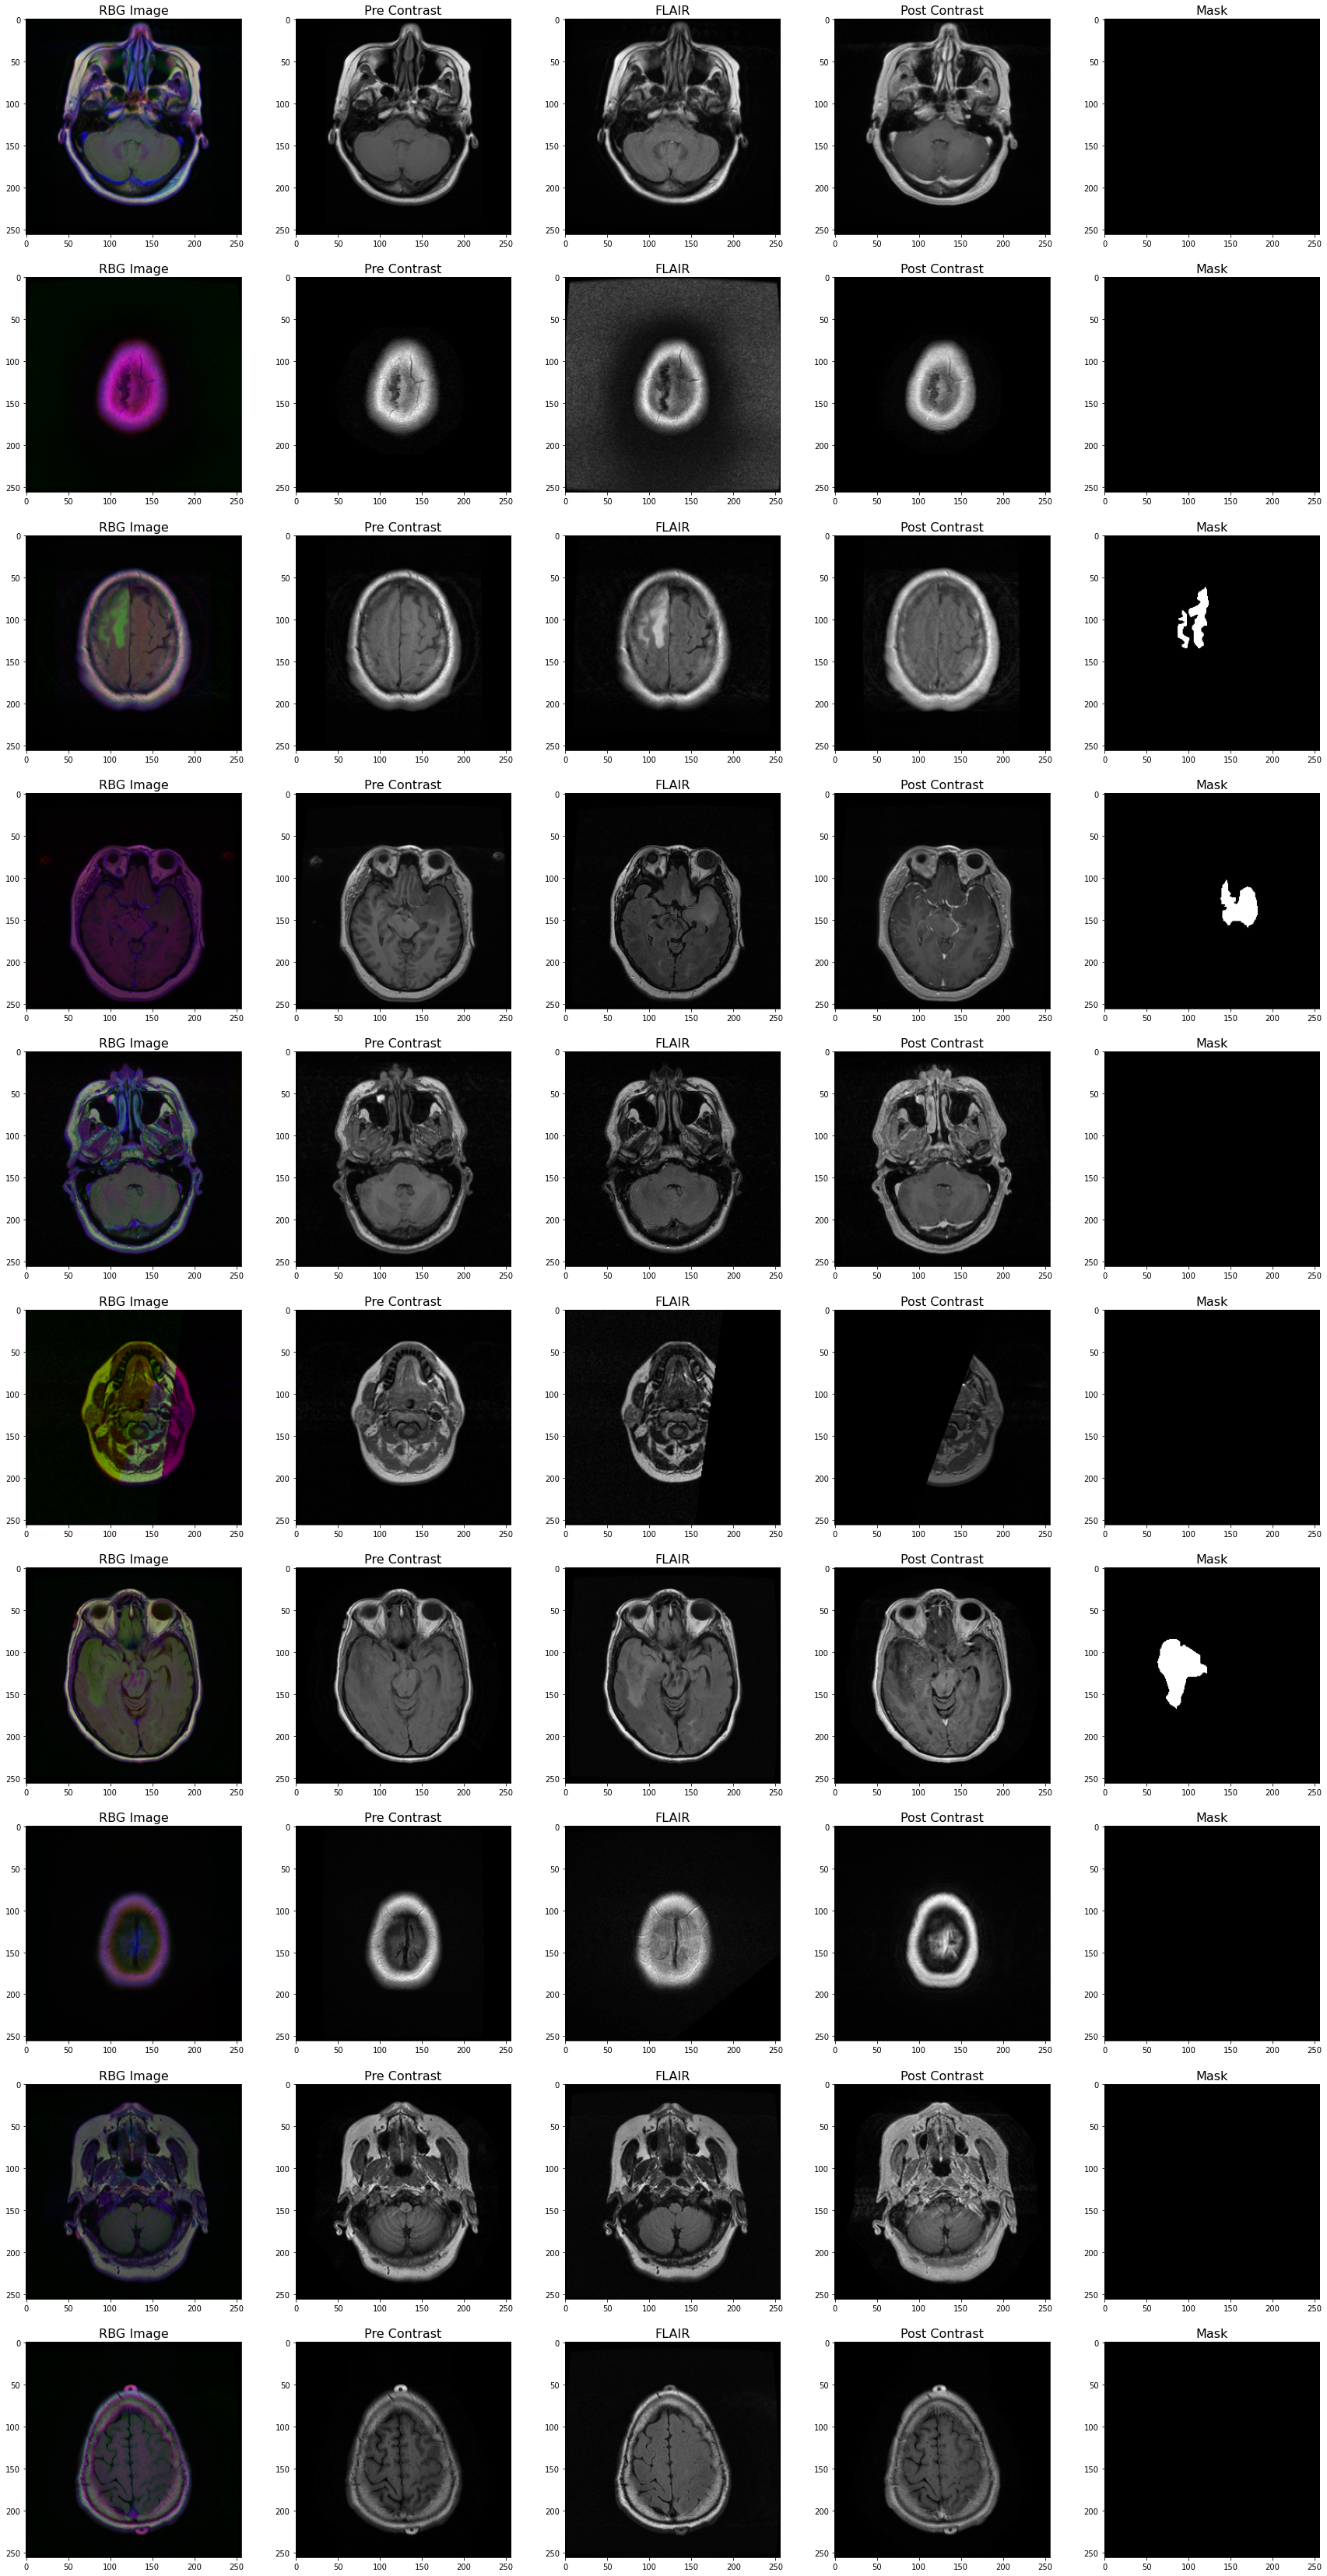

In [ ]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 200, 3)
    
    mri = np.asarray(load_img(
         join(DIR, val_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, val_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

#### Creation de generator de Donnee

In [ ]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [ ]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

#### 4 _ Creation Et Evaluation de Notre Model

In [ ]:
keras.backend.clear_session()

In [ ]:
inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)

u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)

u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv1_1[0][0]']                
                                )                                                             

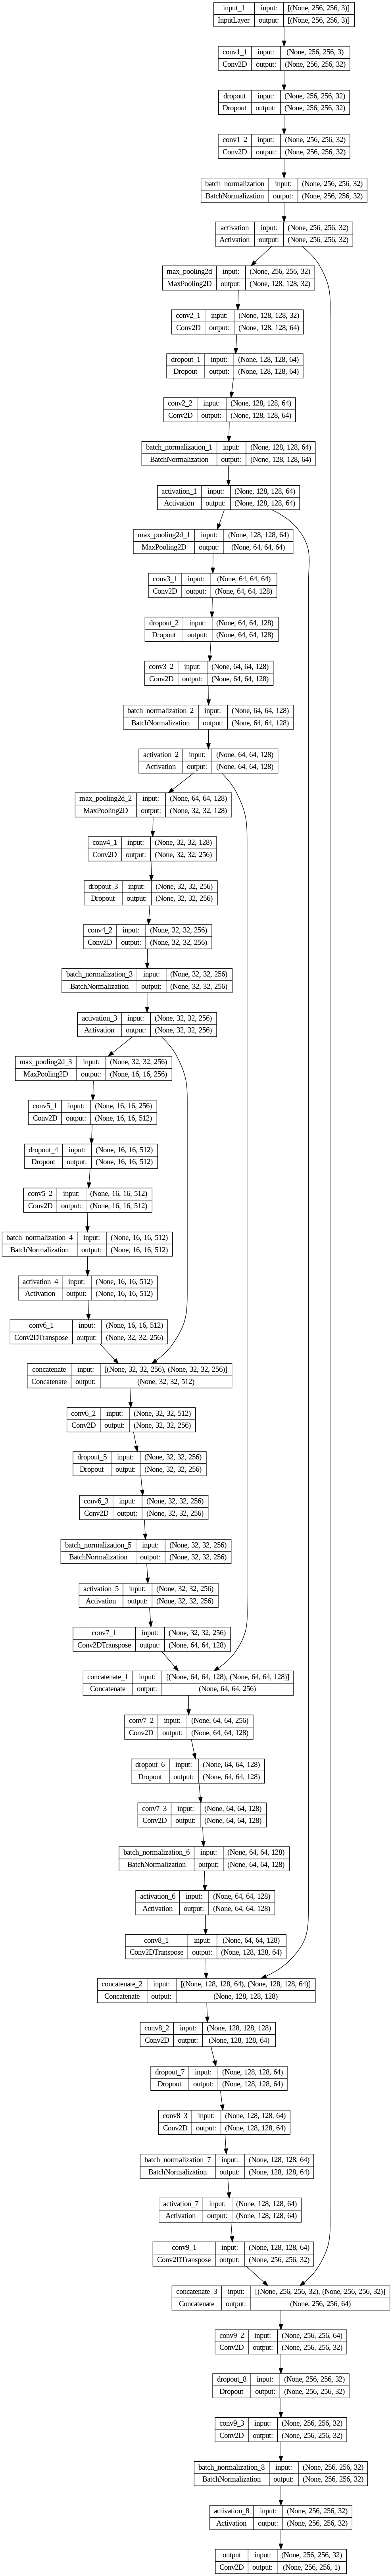

In [ ]:
# Plot de notre model de prediction
keras.utils.plot_model(
    model, 
    to_file='/content/plot.png', 
    show_shapes=True
)

#### Faire l'entrainement de notre Model

In [ ]:
model.compile(
    optimizer=Adam(
        learning_rate=1e-3, 
        ), 
    loss = 'binary_crossentropy',
    metrics=["accuracy"]
)

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint('/content/unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=5,
    callbacks=[model_checkpoint])

Epoch 1/5
94/94 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9746
Epoch 1: val_loss improved from inf to 0.05368, saving model to /content/unet_brain_mri_seg.hdf5
94/94 [==============================] - 647s 7s/step - loss: 0.1987 - accuracy: 0.9746 - val_loss: 0.0537 - val_accuracy: 0.9906
Epoch 2/5
94/94 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9909
Epoch 2: val_loss did not improve from 0.05368
94/94 [==============================] - 90s 958ms/step - loss: 0.0683 - accuracy: 0.9909 - val_loss: 0.0551 - val_accuracy: 0.9906
Epoch 3/5
94/94 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9920
Epoch 3: val_loss did not improve from 0.05368
94/94 [==============================] - 89s 943ms/step - loss: 0.0459 - accuracy: 0.9920 - val_loss: 0.0581 - val_accuracy: 0.9906
Epoch 4/5
94/94 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.9935
Epoch 4: val_loss improved from 0.05368 to 

#### Afficher le graph de preformance de notre model

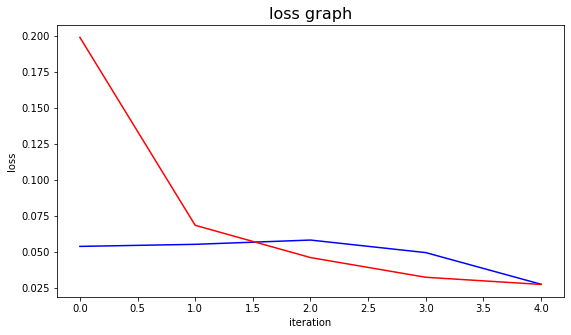

In [ ]:
a = history.history

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.set_title('loss graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')

plt.show()

#### Faire le test et evaluation de notre Model

In [ ]:
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

In [ ]:
model = keras.models.load_model('unet_brain_mri_seg.hdf5')
preds = model.predict(x / 255)

1/1 [==============================] - 0s 24ms/step


#### visualiser la Prediction de Notre Images 

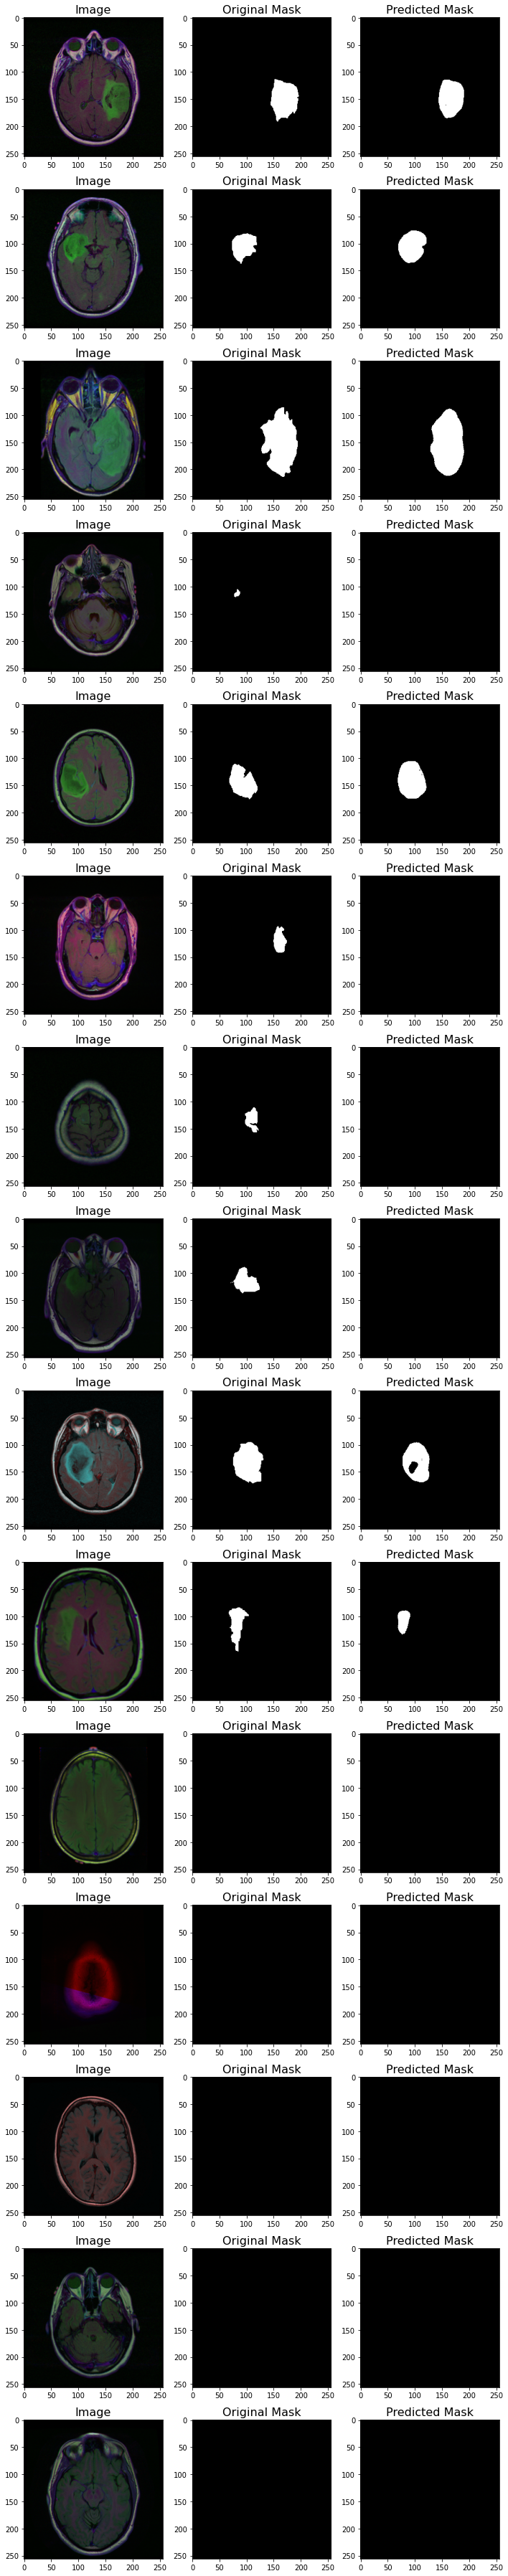

In [ ]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')
        
plt.tight_layout()
plt.show()